In [1]:
import sklearn
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ------------------------------------------------------------------
# Read the settings json
# ------------------------------------------------------------------
with open('mushroom_features.json','r') as f:
    colmap = json.load(f)

In [3]:
# ------------------------------------------------------------------
# Label the data
# This is pulled from the data description
# ------------------------------------------------------------------
df = pd.read_csv('agaricus-lepiota.data')
columns = ['edibility','cap-shape','cap-surface','cap-color','bruises?','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat']
df.columns = columns
keepcolumns = [list(i.keys())[0] for i in colmap]
df = df[keepcolumns].copy()

In [4]:
# ------------------------------------------------------------------
# Split into poisonous/non-poisonous
# ------------------------------------------------------------------
tmpmask = df['edibility'] == 'e'
nonpsn  = df.loc[tmpmask].copy()
psn     = df.loc[~tmpmask].copy()
testdf  = df[set(keepcolumns)-set(['edibility'])]


In [5]:
# ------------------------------------------------------------------
# Apply the weights to the 
# ------------------------------------------------------------------
testdf['score'] = 0
for idx in testdf.index:
    # ------------------------------------------------------------------
    # Going through the features from the json
    # ------------------------------------------------------------------
    for fdict in colmap:
        col = list(fdict.keys())[0]
        # ------------------------------------------------------------------
        # If the column has been removed, skip
        # ------------------------------------------------------------------
        if col not in testdf:
            continue
        val  = testdf.loc[idx,col]
        # ------------------------------------------------------------------
        # There are some values that aren't represented in the description
        # ------------------------------------------------------------------
        if val not in fdict[col]:
            print(f'val not found:{val}')
            continue
        # ------------------------------------------------------------------
        # Increment
        # ------------------------------------------------------------------
        testdf.loc[idx,'score'] += fdict[col]['weight'] * fdict[col][val]
testdf

,bruises?,odor,veil-color,cap-surface,stalk-surface-above-ring,stalk-shape,veil-type,spore-print-color,stalk-surface-below-ring,cap-color,stalk-color-above-ring,habitat,gill-color,stalk-color-below-ring,score
0,t,a,w,s,s,e,p,n,s,y,w,g,k,w,66
1,t,l,w,s,s,e,p,n,s,w,w,m,n,w,70
2,t,p,w,y,s,e,p,k,s,w,w,u,n,w,67
3,f,n,w,s,s,t,p,n,s,g,w,g,k,w,67
4,t,a,w,y,s,e,p,k,s,y,w,g,n,w,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,f,n,o,s,s,e,p,b,s,n,o,l,y,o,64
8119,f,n,n,s,s,e,p,b,s,n,o,l,y,o,63
8120,f,n,o,s,s,e,p,b,s,n,o,l,n,o,64
8121,f,y,w,y,s,t,p,w,k,n,w,l,b,w,55


In [6]:
# ------------------------------------------------------------------
# Cut off the sets
# ------------------------------------------------------------------
cutoff = testdf['score'].quantile(.75)
tmpmask = testdf['score'] >= cutoff
top_25 = testdf.loc[tmpmask].copy()
top_25

,bruises?,odor,veil-color,cap-surface,stalk-surface-above-ring,stalk-shape,veil-type,spore-print-color,stalk-surface-below-ring,cap-color,stalk-color-above-ring,habitat,gill-color,stalk-color-below-ring,score
0,t,a,w,s,s,e,p,n,s,y,w,g,k,w,66
1,t,l,w,s,s,e,p,n,s,w,w,m,n,w,70
2,t,p,w,y,s,e,p,k,s,w,w,u,n,w,67
3,f,n,w,s,s,t,p,n,s,g,w,g,k,w,67
5,t,a,w,s,s,e,p,k,s,w,w,m,g,w,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8093,f,n,w,s,k,e,p,w,s,g,w,g,g,w,73
8095,f,n,w,f,k,e,p,w,s,w,w,g,w,w,72
8098,f,n,w,f,k,e,p,w,k,w,w,g,w,w,71
8108,f,n,w,s,s,e,p,w,s,w,w,g,w,w,76


In [7]:
# ------------------------------------------------------------------
# Cut off the sets
# ------------------------------------------------------------------
testdf['stewability'] = 0
testdf.loc[tmpmask,'stewability'] = 1

In [8]:
from sklearn.preprocessing import OneHotEncoder
# ------------------------------------------------------------------
# Encode the columns
# ------------------------------------------------------------------
x = testdf.drop(['score','stewability'],axis=1)
xcols = x.columns.to_list()
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(x)
x = enc.transform(x).toarray()

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------------
# Split the data set
# ------------------------------------------------------------------
y = testdf['stewability'].to_numpy()
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=1)


In [10]:
# ------------------------------------------------------------------
# Create the model
# ------------------------------------------------------------------
model = RandomForestClassifier(random_state=1)
model.fit(x_train,y_train)
# ------------------------------------------------------------------
# Run the model
# ------------------------------------------------------------------
y_pred = model.predict(x_test)

<AxesSubplot:>

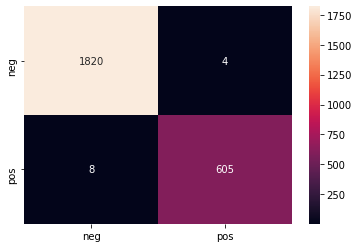

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# ------------------------------------------------------------------
# Confusion matrix
# ------------------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])


In [12]:
finaldf = df.copy()
# ------------------------------------------------------------------
# Run for edible and non-edible
# ------------------------------------------------------------------
finaldf['prediction'] = model.predict(x)
tmpmask = finaldf['edibility'] == 'e'
widowersdf    = finaldf.loc[~tmpmask]
deliciousstew = finaldf.loc[tmpmask]

In [ ]:
# ------------------------------------------------------------------
# Random Forest reports (visualization and feature importance)
# ------------------------------------------------------------------

In [13]:
from sklearn import metrics

def getresults(y_test,y_pred):
    return "F1:", metrics.f1_score(y_test,y_pred),"Accuracy:", metrics.accuracy_score(y_test,y_pred)
	
getresults(y_test,y_pred)

('F1:', 0.9901800327332242, 'Accuracy:', 0.9950759130077965)

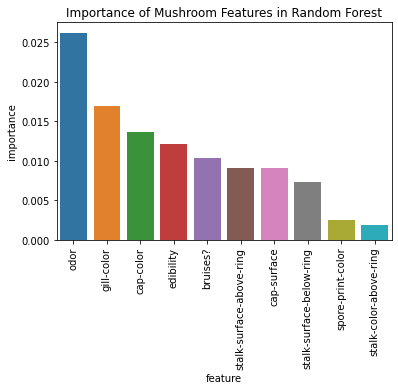

In [22]:
# Estimate Feature Importance

clf_features = pd.DataFrame(sorted(list(zip(df.columns, model.feature_importances_)), key=lambda x: abs(x[1]), reverse=True)[:10], columns=['feature','importance'])
g = sns.barplot(x='feature', y='importance', data=clf_features)
g.set_title(f'Importance of Mushroom Features in Random Forest')
g.set_xticklabels(labels=clf_features.feature,rotation=90)
plt.show()

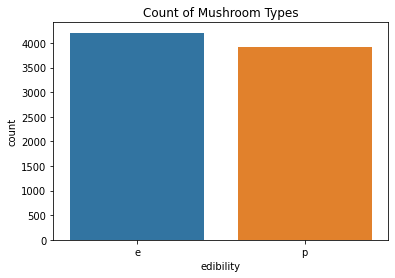

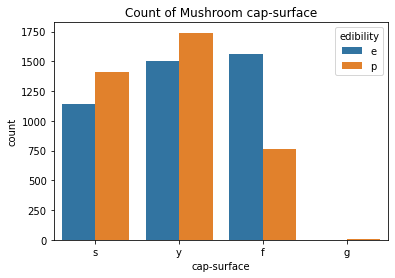

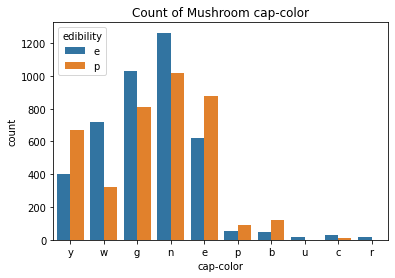

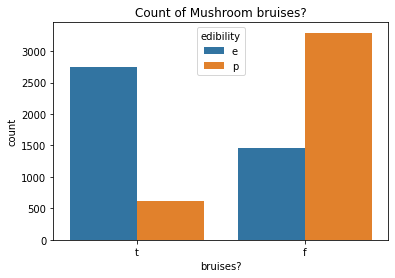

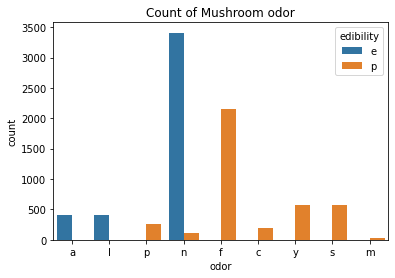

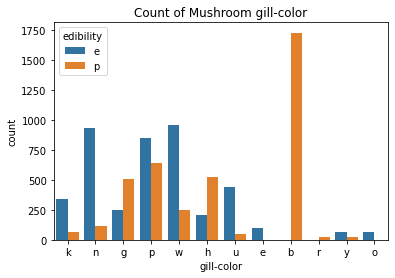

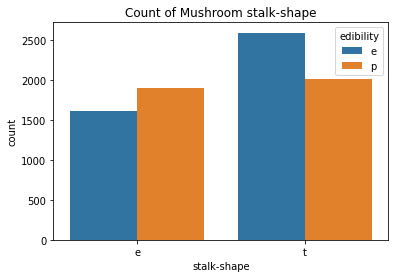

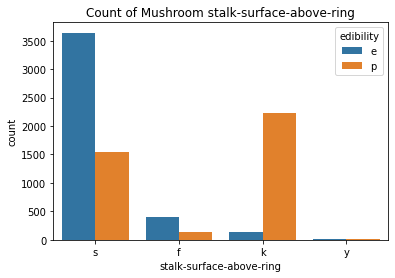

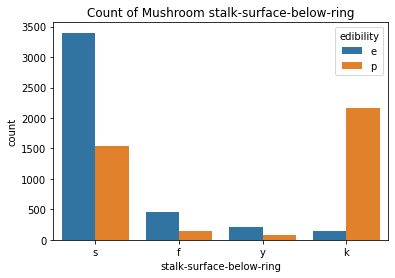

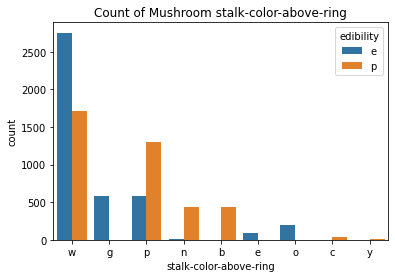

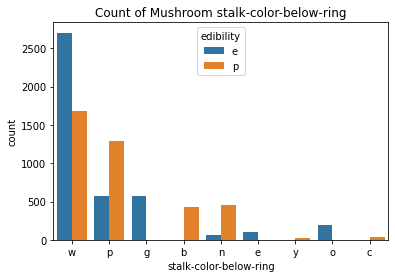

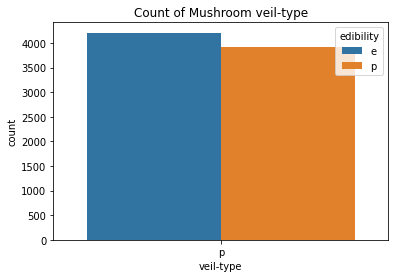

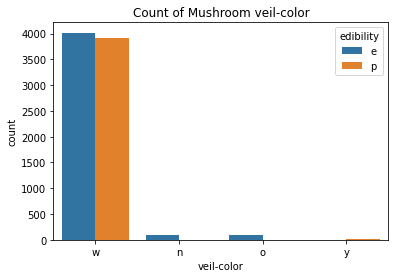

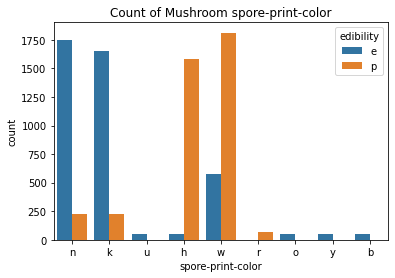

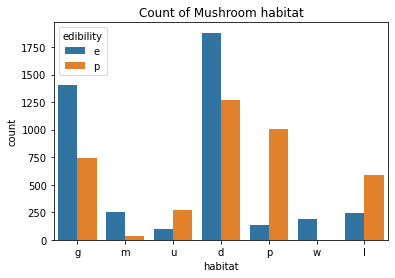

In [14]:
# ------------------------------------------------------------------
# Histograms of columns
# ------------------------------------------------------------------

for i in df.columns:
    if i != 'edibility':
        g = sns.countplot(x=i, hue='edibility', data=df)
        g.set_title(f'Count of Mushroom {i}')
        g.set_xticklabels(labels=df[i].unique())
    else:
        sns.countplot(x='edibility',data=df).set_title('Count of Mushroom Types')
    plt.show()

edibility


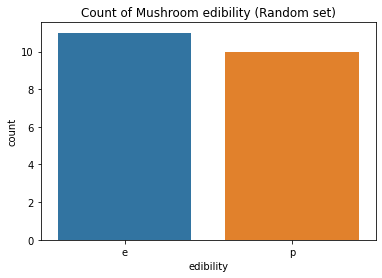

cap-surface


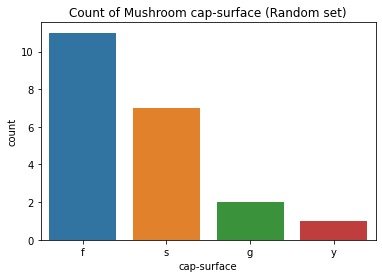

cap-color


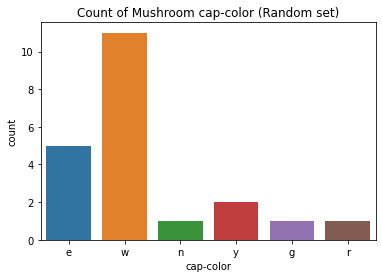

bruises?


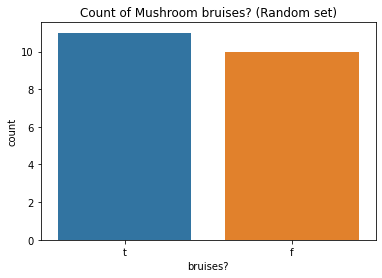

odor


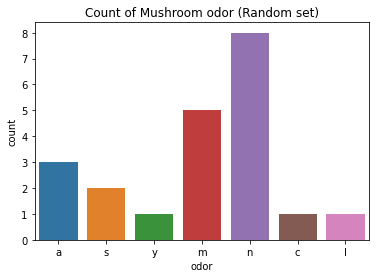

gill-color


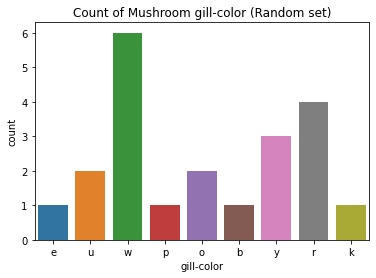

stalk-shape


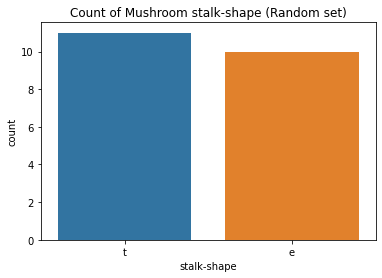

stalk-surface-above-ring


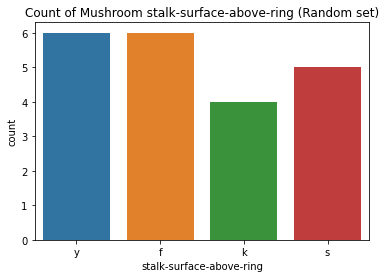

stalk-surface-below-ring


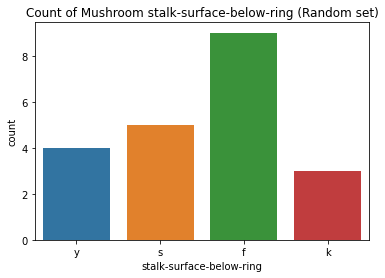

stalk-color-above-ring


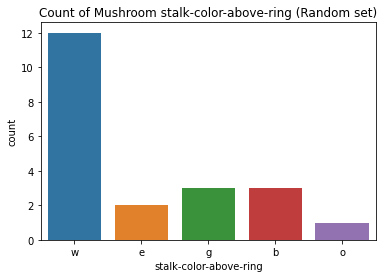

stalk-color-below-ring


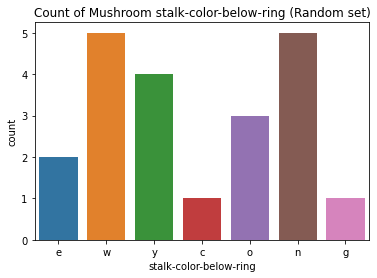

veil-type


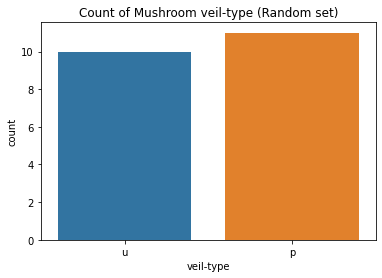

veil-color


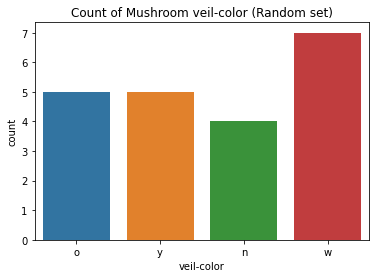

spore-print-color


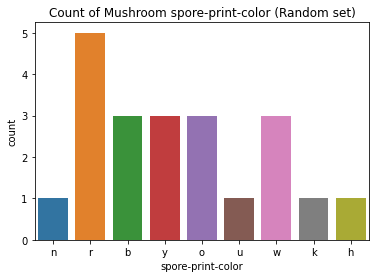

habitat


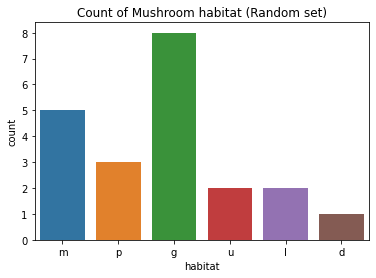

In [96]:
import random
random.seed(1000)
# ------------------------------------------------------------------
# Creating an example set to run this on
# ------------------------------------------------------------------
choiceset = []
for coldict in colmap:
    choiceset.append([i for i in coldict[list(coldict.keys())[0]].keys() if i != 'weight'])
randat = []
for i in range(1000):
    randat.append([random.choice(i) for i in choiceset])
randf = pd.DataFrame(randat,columns=df.columns)
ranx = enc.transform(randf.drop('edibility',axis=1)[testdf.columns]).toarray()
randf['use'] = model.predict(ranx)
tmpmask = randf['use'] == 1
preddf = randf[tmpmask].copy()
for i in preddf.columns:
    if i != 'use':
        print(i)
        g = sns.countplot(x=i, data=preddf)
        g.set_title(f'Count of Mushroom {i} (Random set)')
        g.set_xticklabels(labels=preddf[i].unique())
    else:
        continue
    plt.show()

Conclusion

The Random Forest model we've run on this data has been shown to be extremely accurate when predicting "tastiness" of a mushroom (ignoring its edibility for obvious reasons). So whether your husband has bought you the diamond ring of your dreams or if he's dropped the secret family bomb, this model will help you make the stew of your heart's desire!